In [107]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [108]:
# Load the training data
train_df = pd.read_csv('bike_train.csv')
test_df = pd.read_csv('bike_test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nFirst few rows of training data:")
train_df.head()

Training data shape: (10450, 12)
Test data shape: (2613, 9)

First few rows of training data:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [109]:
# Check for duplicate datetime entries and aggregate
print("Checking for duplicate datetime entries...")
print(f"Total rows before aggregation: {len(train_df)}")
print(f"Unique datetimes: {train_df['datetime'].nunique()}")
print(f"Duplicate datetimes: {len(train_df) - train_df['datetime'].nunique()}")

# Show example of duplicates if they exist
duplicates = train_df[train_df.duplicated(subset=['datetime'], keep=False)].sort_values('datetime')
if len(duplicates) > 0:
    print(f"\nFound {len(duplicates)} rows with duplicate datetimes")
    print("\nExample duplicates (same datetime, different conditions):")
    print(duplicates.head(12)[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'count']])
    
    # Aggregate by summing counts for the same datetime/hour
    print("\n[Applying] Summing counts for duplicate datetimes...")
    print("Aggregation strategy:")
    print("  - count, casual, registered: SUM (total rentals for that hour)")
    print("  - temp, atemp, humidity, windspeed: MEAN (average conditions)")
    print("  - season, holiday, workingday, weather: FIRST (assuming same for that hour)")
    
    train_df = train_df.groupby('datetime', as_index=False).agg({
        'season': 'first',
        'holiday': 'first',
        'workingday': 'first',
        'weather': 'first',
        'temp': 'mean',
        'atemp': 'mean',
        'humidity': 'mean',
        'windspeed': 'mean',
        'casual': 'sum',
        'registered': 'sum',
        'count': 'sum'  # Sum all counts for the same hour
    })
    
    print(f"\nAfter aggregation: {len(train_df)} rows")
    print(f"Rows removed: {len(duplicates) - train_df['datetime'].nunique()}")
else:
    print("\nNo duplicate datetimes found.")

Checking for duplicate datetime entries...
Total rows before aggregation: 10450
Unique datetimes: 10450
Duplicate datetimes: 0

No duplicate datetimes found.


In [110]:
# Data information
print("Training Data Info:")
print(train_df.info())
print("\nBasic Statistics:")
train_df.describe()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  float64
 7   humidity    10450 non-null  int64  
 8   windspeed   10450 non-null  float64
 9   casual      10450 non-null  int64  
 10  registered  10450 non-null  int64  
 11  count       10450 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 979.8+ KB
None

Basic Statistics:


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000
mean,2.507943,0.028804,0.675694,1.413876,20.191700,23.605793,61.924211,12.765259,35.869091,154.511675,190.410526
std,1.116946,0.167263,0.468137,0.632258,7.792683,8.478045,19.245193,8.102821,49.629436,150.861267,181.038755
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.450050,16.000000,117.000000,143.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,221.000000,283.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [111]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Missing values in test data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


## 2. Feature Engineering

In [112]:
def parse_datetime(df):
    """Extract datetime features from the datetime column"""
    df = df.copy()
    
    # Parse datetime - handle multiple formats
    # Train data: YYYY-MM-DD HH:MM:SS, Test data: DD-MM-YYYY HH:MM
    df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', dayfirst=True)
    
    # Extract time-based features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['dayofyear'] = df['datetime'].dt.dayofyear
    
    # Create cyclical features for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Create cyclical features for month (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Create cyclical features for day of week (7-day cycle)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df

def create_features(df):
    """Create additional features"""
    df = df.copy()
    
    # One-hot encoding for season (1=Spring, 2=Summer, 3=Fall, 4=Winter)
    df['season_spring'] = (df['season'] == 1).astype(int)
    df['season_summer'] = (df['season'] == 2).astype(int)
    df['season_fall'] = (df['season'] == 3).astype(int)
    df['season_winter'] = (df['season'] == 4).astype(int)
    
    # One-hot encoding for weather (1=Clear, 2=Mist, 3=Light Rain/Snow, 4=Heavy Rain/Snow)
    df['weather_clear'] = (df['weather'] == 1).astype(int)
    df['weather_mist'] = (df['weather'] == 2).astype(int)
    df['weather_light_rain'] = (df['weather'] == 3).astype(int)
    df['weather_heavy_rain'] = (df['weather'] == 4).astype(int)
    
    # Peak hours (morning and evening rush)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | 
                          (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    
    # Time of day categories
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[0, 6, 12, 18, 24],
                               labels=['night', 'morning', 'afternoon', 'evening'],
                               include_lowest=True)
    df['time_of_day'] = df['time_of_day'].cat.codes
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Interaction features
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_windspeed'] = df['temp'] * df['windspeed']
    df['feels_like_diff'] = df['atemp'] - df['temp']
    
    # Working day and hour interaction
    df['workingday_hour'] = df['workingday'] * df['hour']
    
    return df

# Apply feature engineering
train_df = parse_datetime(train_df)
train_df = create_features(train_df)

test_df = parse_datetime(test_df)
test_df = create_features(test_df)

print("Feature engineering completed!")
print(f"\nTraining data shape after feature engineering: {train_df.shape}")
print(f"Test data shape after feature engineering: {test_df.shape}")
print("\nNew features created:")
print(train_df.columns.tolist())

Feature engineering completed!

Training data shape after feature engineering: (10450, 40)
Test data shape after feature engineering: (2613, 37)

New features created:
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'season_spring', 'season_summer', 'season_fall', 'season_winter', 'weather_clear', 'weather_mist', 'weather_light_rain', 'weather_heavy_rain', 'is_rush_hour', 'time_of_day', 'is_weekend', 'temp_humidity', 'temp_windspeed', 'feels_like_diff', 'workingday_hour']


## 3. Exploratory Data Analysis (EDA)

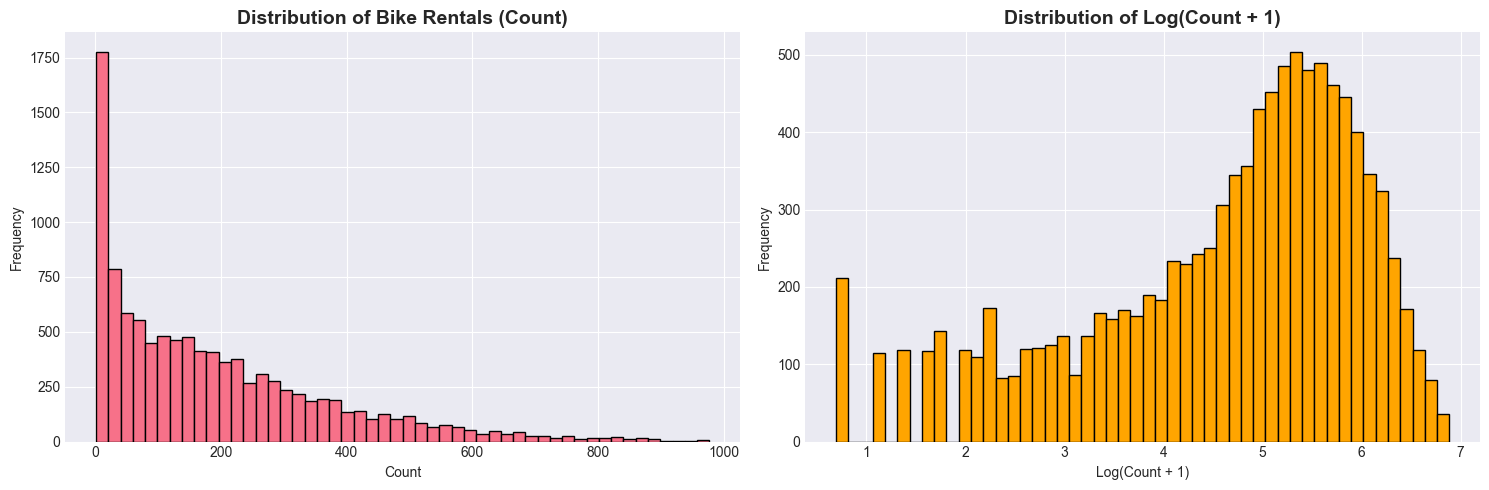

Skewness of count: 1.26
Skewness of log(count+1): -0.90


In [113]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution
axes[0].hist(train_df['count'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Bike Rentals (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')

# Log-transformed distribution
axes[1].hist(np.log1p(train_df['count']), bins=50, edgecolor='black', color='orange')
axes[1].set_title('Distribution of Log(Count + 1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Count + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Skewness of count: {train_df['count'].skew():.2f}")
print(f"Skewness of log(count+1): {np.log1p(train_df['count']).skew():.2f}")

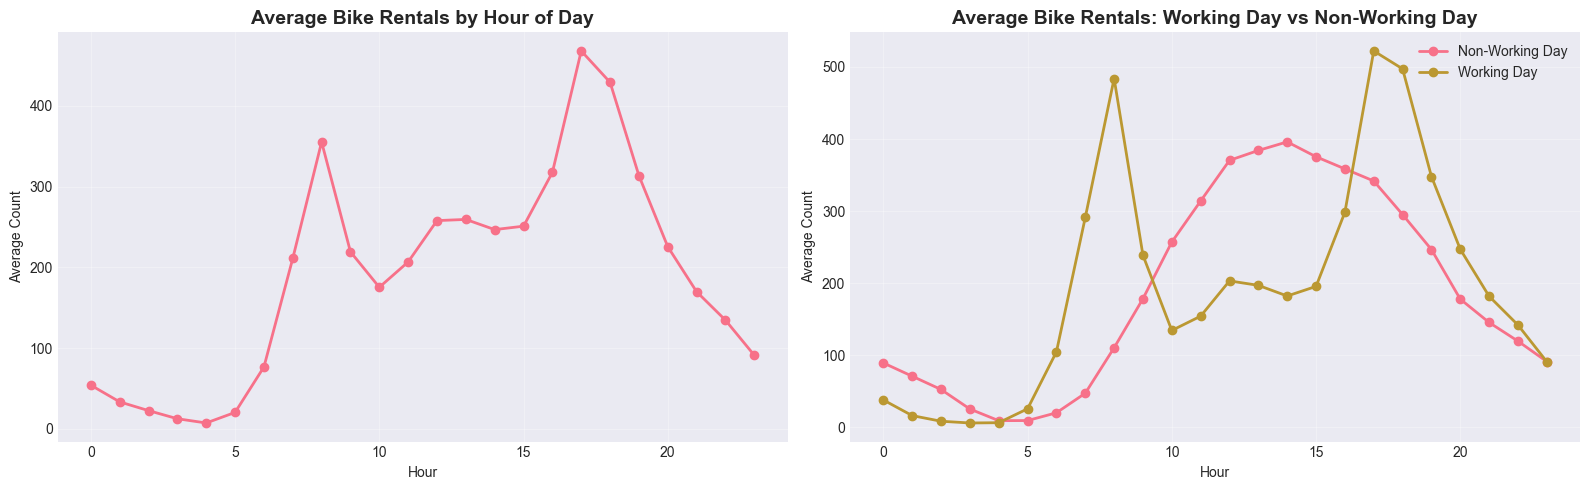

In [114]:
# Bike rentals by hour
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

hourly_data = train_df.groupby('hour')['count'].mean()
axes[0].plot(hourly_data.index, hourly_data.values, marker='o', linewidth=2)
axes[0].set_title('Average Bike Rentals by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Average Count')
axes[0].grid(True, alpha=0.3)

# By hour and working day
hourly_working = train_df.groupby(['hour', 'workingday'])['count'].mean().unstack()
hourly_working.plot(ax=axes[1], marker='o', linewidth=2)
axes[1].set_title('Average Bike Rentals: Working Day vs Non-Working Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Average Count')
axes[1].legend(['Non-Working Day', 'Working Day'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

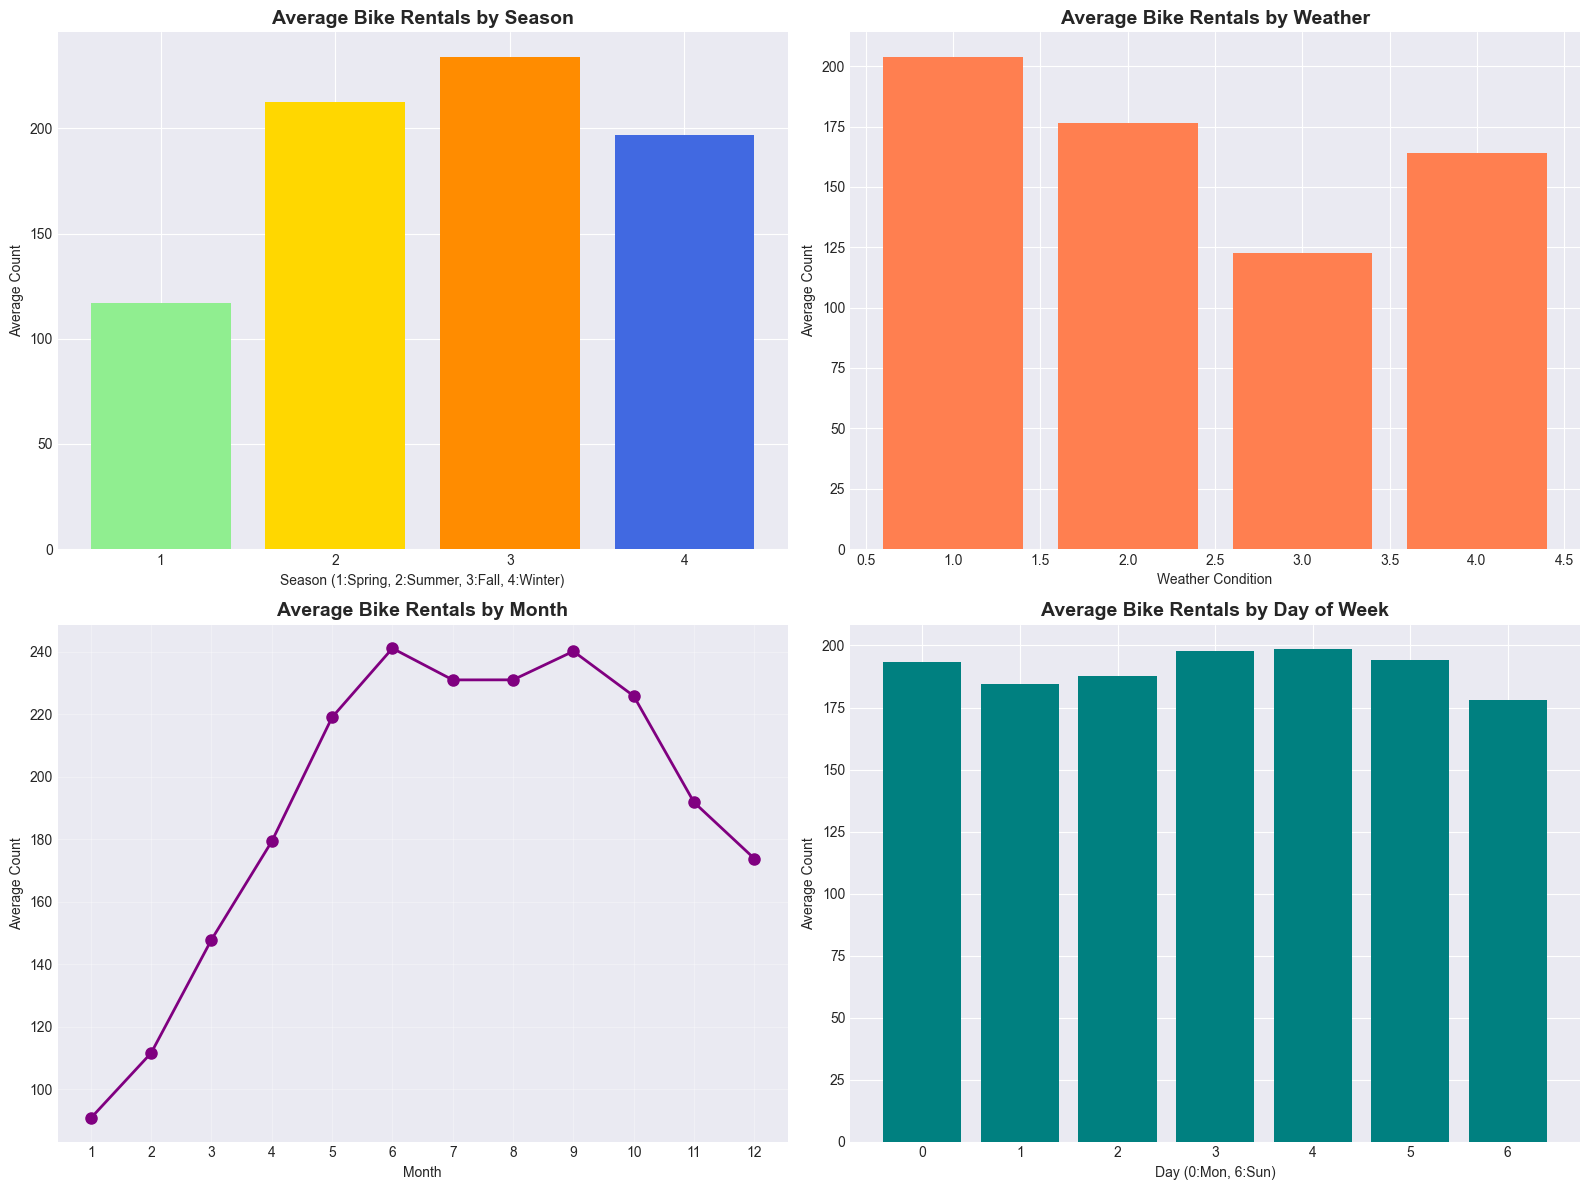

In [115]:
# Bike rentals by various categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By season
season_data = train_df.groupby('season')['count'].mean()
axes[0, 0].bar(season_data.index, season_data.values, color=['#90EE90', '#FFD700', '#FF8C00', '#4169E1'])
axes[0, 0].set_title('Average Bike Rentals by Season', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season (1:Spring, 2:Summer, 3:Fall, 4:Winter)')
axes[0, 0].set_ylabel('Average Count')
axes[0, 0].set_xticks([1, 2, 3, 4])

# By weather
weather_data = train_df.groupby('weather')['count'].mean()
axes[0, 1].bar(weather_data.index, weather_data.values, color='coral')
axes[0, 1].set_title('Average Bike Rentals by Weather', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Weather Condition')
axes[0, 1].set_ylabel('Average Count')

# By month
month_data = train_df.groupby('month')['count'].mean()
axes[1, 0].plot(month_data.index, month_data.values, marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_title('Average Bike Rentals by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Count')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# By day of week
dow_data = train_df.groupby('dayofweek')['count'].mean()
axes[1, 1].bar(dow_data.index, dow_data.values, color='teal')
axes[1, 1].set_title('Average Bike Rentals by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day (0:Mon, 6:Sun)')
axes[1, 1].set_ylabel('Average Count')
axes[1, 1].set_xticks(range(7))

plt.tight_layout()
plt.show()

Correlation with target variable (count):
count                 1.000000
is_rush_hour          0.459822
hour                  0.404188
temp                  0.396451
time_of_day           0.394440
atemp                 0.390642
temp_windspeed        0.305615
workingday_hour       0.263922
year                  0.257987
dayofyear             0.166788
month                 0.165475
quarter               0.160333
season                0.160333
season_fall           0.139522
feels_like_diff       0.131248
windspeed             0.105318
weather_clear         0.104266
season_summer         0.070937
temp_humidity         0.064352
day                   0.022141
season_winter         0.020952
workingday            0.017361
dayofweek_sin        -0.001394
weather_heavy_rain   -0.001427
holiday              -0.005615
dayofweek            -0.006489
is_weekend           -0.015754
dayofweek_cos        -0.025956
weather_mist         -0.045351
weather_light_rain   -0.109435
weather              -0.1244

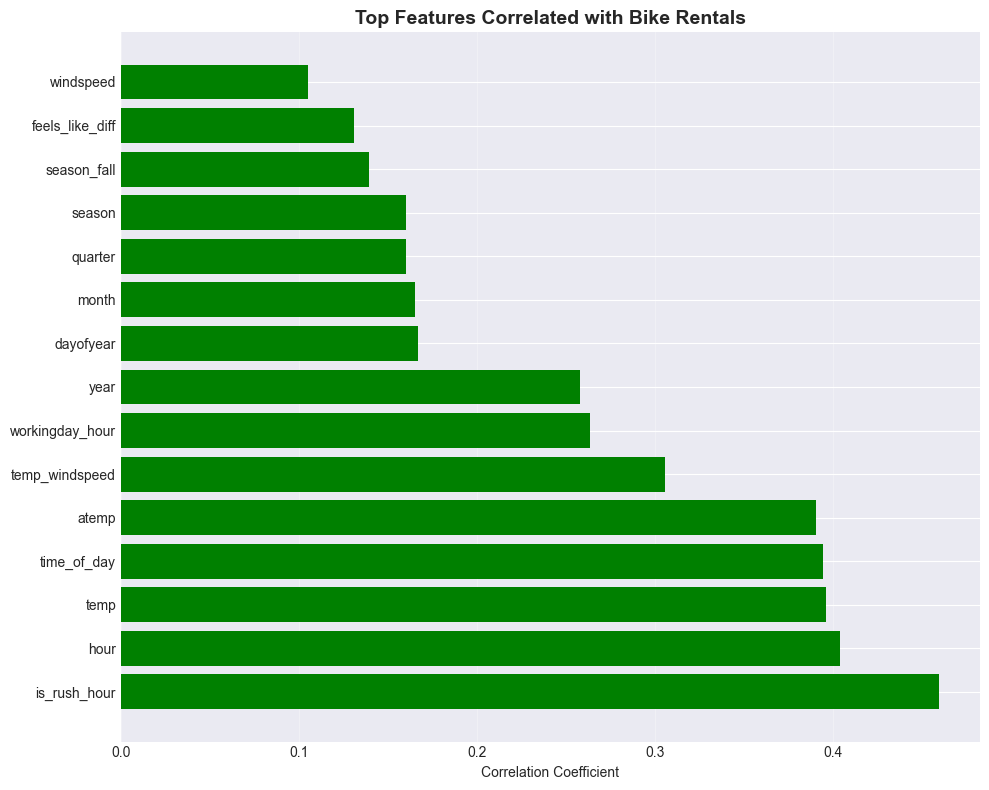

In [116]:
# Correlation with target variable
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('count')  # Remove target
numerical_cols = [col for col in numerical_cols if col not in ['casual', 'registered']]  # Remove if present

correlations = train_df[numerical_cols + ['count']].corr()['count'].sort_values(ascending=False)
print("Correlation with target variable (count):")
print(correlations)

# Plot top correlations
plt.figure(figsize=(10, 8))
top_corr = correlations[1:16]  # Top 15 (excluding count itself)
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top Features Correlated with Bike Rentals', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

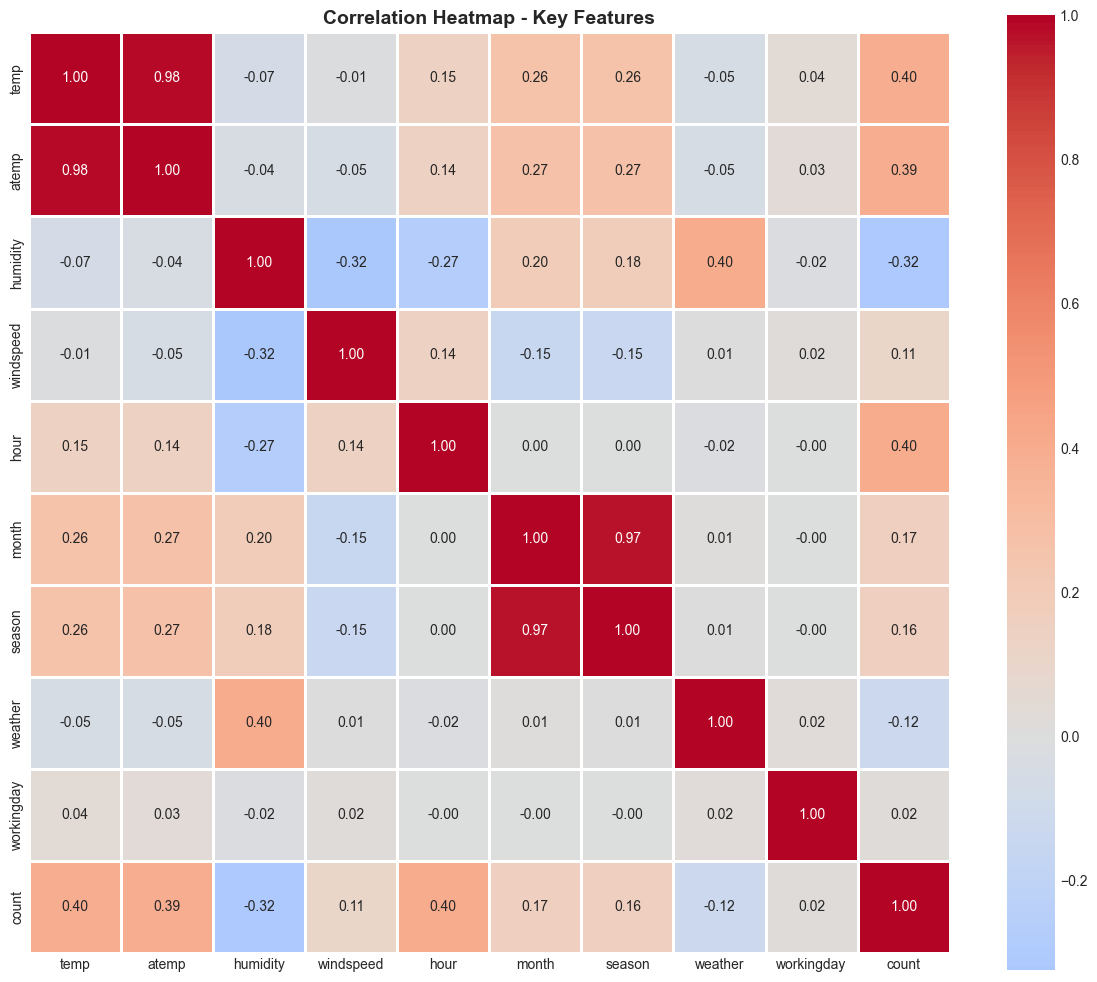

In [117]:
# Correlation heatmap for key features
key_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month', 'season', 'weather', 'workingday', 'count']
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[key_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

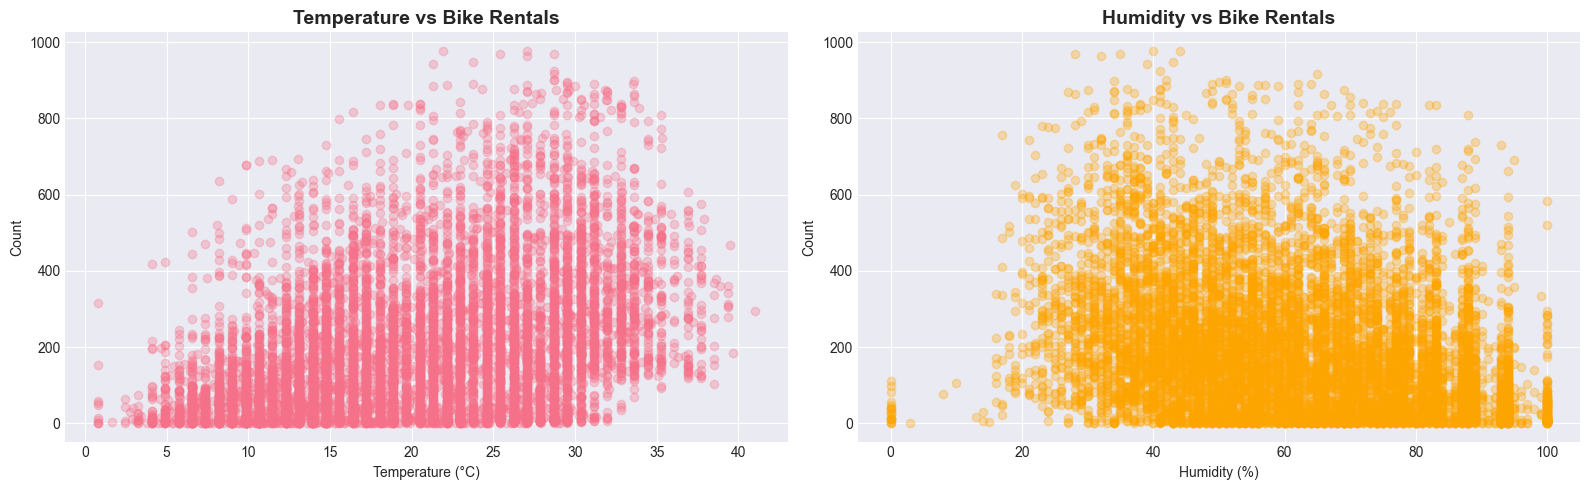

In [118]:
# Weather conditions impact
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Temperature vs Count
axes[0].scatter(train_df['temp'], train_df['count'], alpha=0.3)
axes[0].set_title('Temperature vs Bike Rentals', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Count')

# Humidity vs Count
axes[1].scatter(train_df['humidity'], train_df['count'], alpha=0.3, color='orange')
axes[1].set_title('Humidity vs Bike Rentals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Humidity (%)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Data Preparation for Modeling

In [119]:
# Separate features and target
# Drop columns that are not needed for modeling
drop_cols = ['datetime', 'casual', 'registered', 'count']
drop_cols = [col for col in drop_cols if col in train_df.columns]

X_full = train_df.drop(columns=drop_cols)
y = train_df['count']

# Feature selection: Remove low-correlation and redundant features
# Remove features that may cause multicollinearity or have low predictive power
features_to_drop = [
    'season',  # Replaced by one-hot encoded season features
    'weather',  # Replaced by one-hot encoded weather features
    # 'temp',  # Removing as requested
    # 'atemp',  # Highly correlated with temp (0.98)
    'dayofyear',  # Redundant with month/day
    'day',  # Less important than hour, month, dayofweek
    'year',  # Only 2 years in data, captured by other temporal features
    'quarter',  # Redundant with month
    # 'dayofweek_sin', 'dayofweek_cos',  # Simpler to use is_weekend
    # 'feels_like_diff',  # Derived from temp and atemp which are correlated
    # 'humidity',  # Low correlation with target
    # 'windspeed',  # Low correlation with target
    # 'temp_humidity',
    # 'temp_windspeed',
    # 'month',
    # 'month_sin',
    # 'month_cos',
]

# Keep most important features based on correlation and domain knowledge
X = X_full.drop(columns=features_to_drop, errors='ignore')

# For test data
X_test_full = test_df.drop(columns=['datetime'], errors='ignore')
X_test = X_test_full.drop(columns=features_to_drop, errors='ignore')

# Ensure test data has same columns as training data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"\nFeatures removed: {features_to_drop}")
print(f"Features used for modeling ({len(X.columns)}): {X.columns.tolist()}")

Feature matrix shape: (10450, 30)
Target shape: (10450,)
Test data shape: (2613, 30)

Features removed: ['season', 'weather', 'dayofyear', 'day', 'year', 'quarter']
Features used for modeling (30): ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'season_spring', 'season_summer', 'season_fall', 'season_winter', 'weather_clear', 'weather_mist', 'weather_light_rain', 'weather_heavy_rain', 'is_rush_hour', 'time_of_day', 'is_weekend', 'temp_humidity', 'temp_windspeed', 'feels_like_diff', 'workingday_hour']


In [120]:
# Split data for training and validation (90-10 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training set size: {X_train.shape[0]} (90%)")
print(f"Validation set size: {X_val.shape[0]} (10%)")
print(f"Test set size: {X_test.shape[0]}")

# Feature Scaling - Important for linear models with regularization
print("\nApplying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Feature scaling completed!")

Training set size: 9405 (90%)
Validation set size: 1045 (10%)
Test set size: 2613

Applying feature scaling...
Feature scaling completed!


## 5. Model Building and Evaluation

In [121]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, use_log_transform=False):
    """Train and evaluate a model"""
    # Optional: train on log-transformed target for better handling of count data
    if use_log_transform:
        y_train_log = np.log1p(y_train)
        model.fit(X_train, y_train_log)
        y_train_pred = np.expm1(model.predict(X_train))  # Transform back
        y_val_pred = np.expm1(model.predict(X_val))
    else:
        # Train the model
        model.fit(X_train, y_train)
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    # Ensure predictions are non-negative
    y_train_pred = np.maximum(0, y_train_pred)
    y_val_pred = np.maximum(0, y_val_pred)
    
    # Calculate RMSLE (Root Mean Squared Logarithmic Error)
    # RMSLE = sqrt(mean((log(pred + 1) - log(actual + 1))^2))
    train_rmsle = np.sqrt(np.mean((np.log(y_train_pred+1) - np.log(y_train+1))**2))
    val_rmsle = np.sqrt(np.mean((np.log(y_val_pred+1) - np.log(y_val+1))**2))
    
    # Calculate other metrics for additional insight
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"Training RMSLE: {train_rmsle:.4f}")
    print(f"Validation RMSLE: {val_rmsle:.4f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_rmsle': train_rmsle,
        'val_rmsle': val_rmsle,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

# Store results
results = []

In [122]:
# 1. Linear Regression (with log transform)
print("\n" + "="*60)
print("Training Linear Models with Optimized Features")
print("="*60)

lr = LinearRegression()
lr_results = evaluate_model(lr, X_train_scaled, y_train, X_val_scaled, y_val, 
                           "Linear Regression (Log Transform)", use_log_transform=True)
results.append(lr_results) 


Training Linear Models with Optimized Features

Linear Regression (Log Transform)
Training RMSLE: 0.7839
Validation RMSLE: 0.7733
Training RMSE: 125.98
Validation RMSE: 134.89
Training MAE: 82.50
Validation MAE: 86.11
Training R²: 0.5113
Validation R²: 0.4863


In [123]:
# 2. Ridge Regression (Optimized alpha with log transform)
ridge = Ridge(alpha=0.0001, random_state=42)
ridge_results = evaluate_model(ridge, X_train_scaled, y_train, X_val_scaled, y_val, 
                              "Ridge Regression (Log Transform)", use_log_transform=True)
results.append(ridge_results)


Ridge Regression (Log Transform)
Training RMSLE: 0.7839
Validation RMSLE: 0.7733
Training RMSE: 126.01
Validation RMSE: 134.89
Training MAE: 82.52
Validation MAE: 86.12
Training R²: 0.5110
Validation R²: 0.4862


In [124]:
# 3. Lasso Regression (Optimized alpha with log transform)
lasso = Lasso(alpha=0.001, random_state=42, max_iter=20000)
lasso_results = evaluate_model(lasso, X_train_scaled, y_train, X_val_scaled, y_val, 
                              "Lasso Regression (Log Transform)", use_log_transform=True)
results.append(lasso_results)


Lasso Regression (Log Transform)
Training RMSLE: 0.7840
Validation RMSLE: 0.7737
Training RMSE: 125.50
Validation RMSE: 134.68
Training MAE: 82.14
Validation MAE: 85.98
Training R²: 0.5150
Validation R²: 0.4879


In [125]:
# Compare all models
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Train RMSLE': r['train_rmsle'],
    'Val RMSLE': r['val_rmsle'],
    'Train RMSE': r['train_rmse'],
    'Val RMSE': r['val_rmse'],
    'Train MAE': r['train_mae'],
    'Val MAE': r['val_mae'],
    'Train R²': r['train_r2'],
    'Val R²': r['val_r2']
} for r in results])

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))

# Find best model based on validation RMSLE
best_model_idx = comparison_df['Val RMSLE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest Model (lowest validation RMSLE): {best_model_name}")
print(f"Best Validation RMSLE: {comparison_df.loc[best_model_idx, 'Val RMSLE']:.4f}")


MODEL COMPARISON
                            Model  Train RMSLE  Val RMSLE  Train RMSE   Val RMSE  Train MAE   Val MAE  Train R²   Val R²
Linear Regression (Log Transform)     0.783908   0.773270  125.982497 134.887546  82.499547 86.113151  0.511251 0.486273
 Ridge Regression (Log Transform)     0.783899   0.773332  126.011169 134.892353  82.524528 86.121224  0.511028 0.486237
 Lasso Regression (Log Transform)     0.784026   0.773670  125.497324 134.677516  82.142644 85.984804  0.515008 0.487872

Best Model (lowest validation RMSLE): Linear Regression (Log Transform)
Best Validation RMSLE: 0.7733


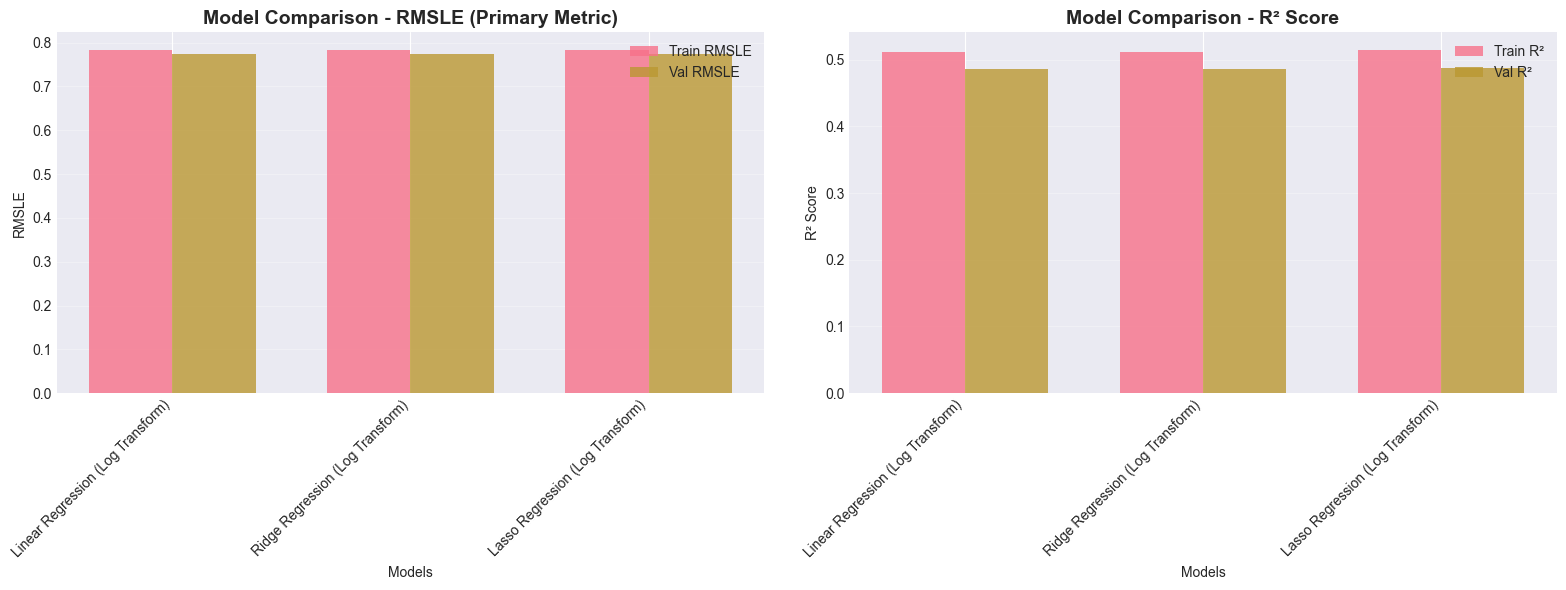

In [126]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = np.arange(len(comparison_df))
width = 0.35

# RMSLE comparison (Primary metric)
axes[0].bar(x_pos - width/2, comparison_df['Train RMSLE'], width, label='Train RMSLE', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Val RMSLE'], width, label='Val RMSLE', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('RMSLE')
axes[0].set_title('Model Comparison - RMSLE (Primary Metric)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Val R²'], width, label='Val R²', alpha=0.8)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [127]:
# Create validation results CSV for analysis
print("Creating validation results file...")

# Get best model from results
best_model = results[best_model_idx]['model']

# Get predictions from best model (using SCALED validation data)
# Remember: model was trained on log-transformed target, so predictions are in log space
val_predictions_log = best_model.predict(X_val_scaled)
val_predictions = np.expm1(val_predictions_log)  # Inverse transform from log space
val_predictions = np.maximum(0, val_predictions)

# Get the datetime values for validation set
# Need to get original indices to match with train_df
val_indices = y_val.index
val_datetime = train_df.loc[val_indices, 'datetime'].values

# Create a simple dataframe with only 3 columns
validation_results = pd.DataFrame({
    'datetime': val_datetime,
    'actual_count': y_val.values,
    'predicted_count': val_predictions
})

# Calculate metrics for display
val_rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(val_predictions)))
absolute_error = np.abs(y_val.values - val_predictions)
percentage_error = np.abs((y_val.values - val_predictions) / (y_val.values + 1)) * 100

# Save to CSV
validation_results.to_csv('validation_results.csv', index=False)

print(f"✓ Validation results saved to: validation_results.csv")
print(f"\nValidation Set Performance:")
print(f"  - Samples: {len(validation_results)}")
print(f"  - RMSLE: {val_rmsle:.4f}")
print(f"  - Mean Absolute Error: {absolute_error.mean():.2f}")
print(f"  - Mean Percentage Error: {percentage_error.mean():.2f}%")
print(f"\nFirst few predictions vs actual:")
print(validation_results.head(10))

Creating validation results file...
✓ Validation results saved to: validation_results.csv

Validation Set Performance:
  - Samples: 1045
  - RMSLE: 0.7733
  - Mean Absolute Error: 86.11
  - Mean Percentage Error: 79.45%

First few predictions vs actual:
             datetime  actual_count  predicted_count
0 2011-02-02 05:00:00             3         5.119225
1 2012-08-16 03:00:00             4        20.473623
2 2011-08-08 20:00:00           286       268.406696
3 2012-01-03 11:00:00            75        55.080542
4 2012-02-02 21:00:00           148        77.024766
5 2012-12-16 20:00:00           122       134.171605
6 2012-10-18 21:00:00           283       162.956288
7 2012-04-13 07:00:00           296       108.793146
8 2012-04-06 18:00:00           484       401.844827
9 2012-04-17 22:00:00           162       107.473942


## 6. Model Predictions and Residual Analysis

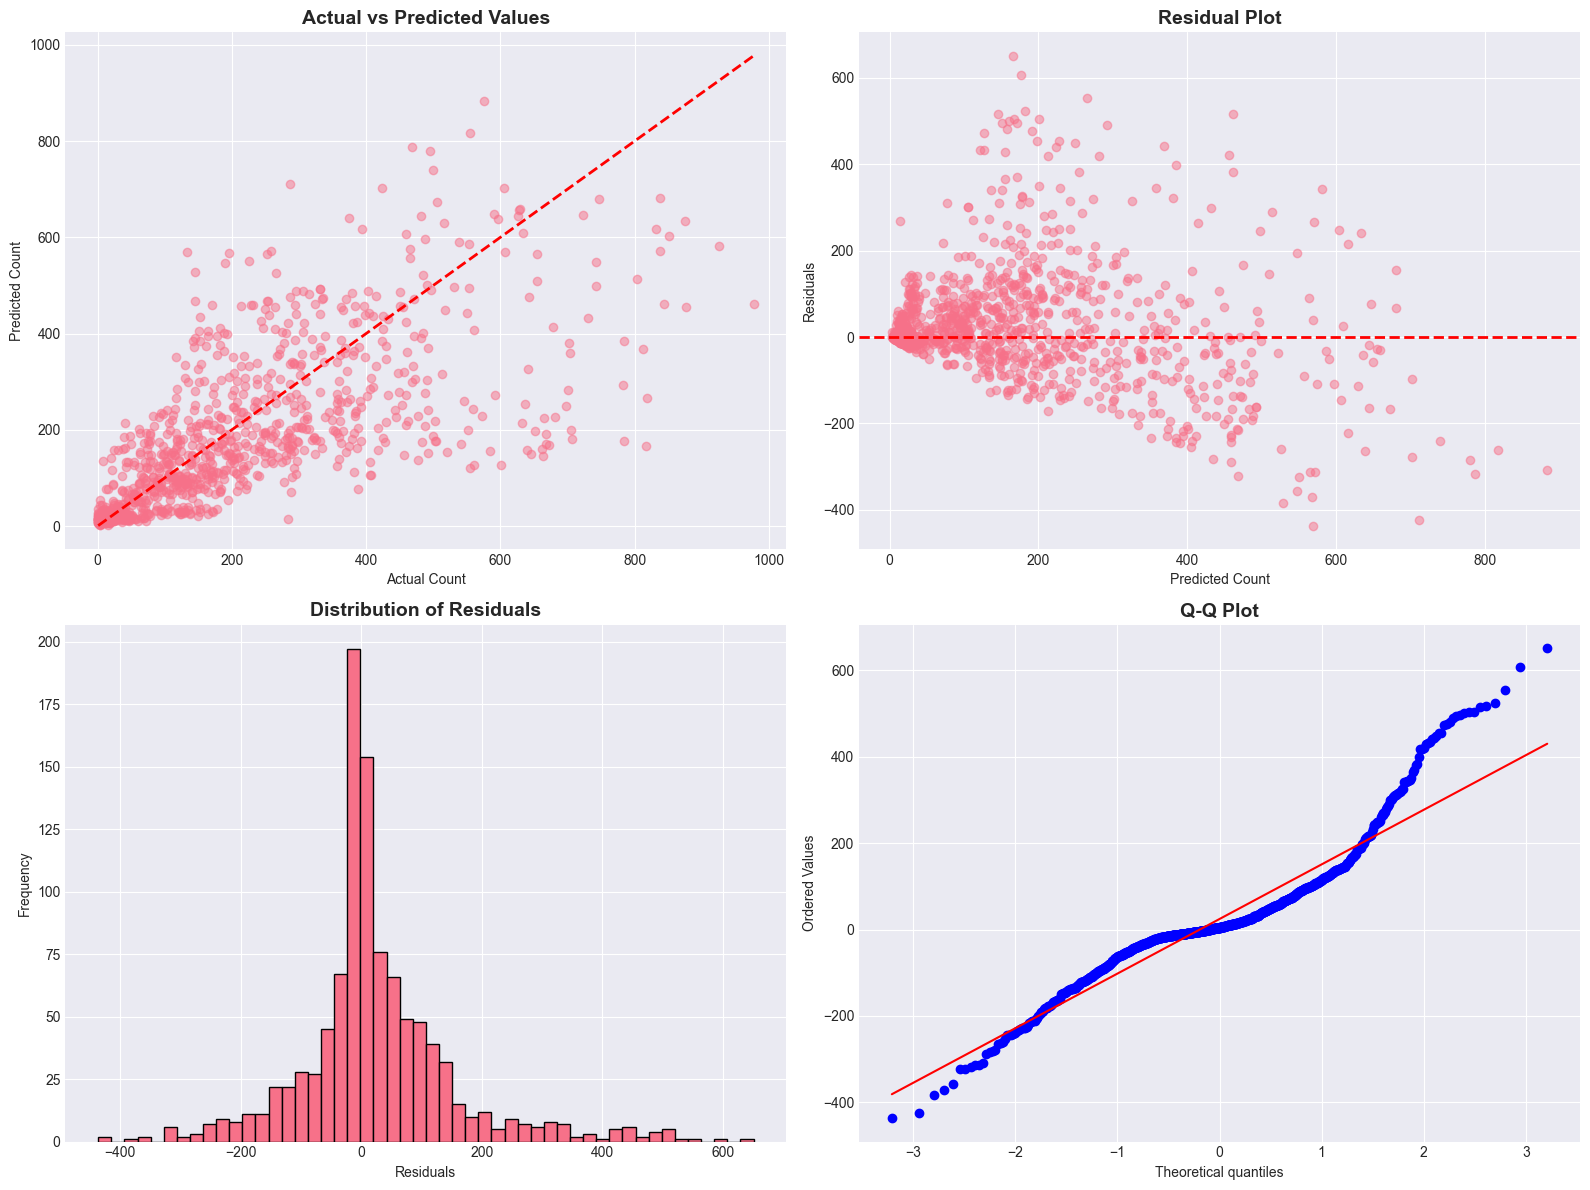


Residual Statistics:
Mean: 24.38
Std: 132.73
Min: -436.80
Max: 651.32


In [128]:
# Get best model
best_model = results[best_model_idx]['model']

# Make predictions (using SCALED validation data and inverse transform)
y_val_pred_log = best_model.predict(X_val_scaled)
y_val_pred = np.expm1(y_val_pred_log)  # Inverse transform from log space
y_val_pred = np.maximum(0, y_val_pred)

# Residual analysis
residuals = y_val - y_val_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted
axes[0, 0].scatter(y_val, y_val_pred, alpha=0.5)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Count')
axes[0, 0].set_ylabel('Predicted Count')
axes[0, 0].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')

# Residual plot
axes[0, 1].scatter(y_val_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Count')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')

# Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.2f}")
print(f"Std: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

## 7. Generate Predictions for Test Set

In [129]:
# Train best model on full training data
print(f"Training {best_model_name} on full training data...")

# Scale full training data with a NEW scaler
full_scaler = StandardScaler()
X_full_scaled = full_scaler.fit_transform(X)
X_full_scaled = pd.DataFrame(X_full_scaled, columns=X.columns)

# Scale test data with the SAME scaler used for full training data
X_test_scaled_final = full_scaler.transform(X_test)
X_test_scaled_final = pd.DataFrame(X_test_scaled_final, columns=X.columns)

# Get the best model type and retrain on full data with log transform
final_model = type(results[best_model_idx]['model'])(**results[best_model_idx]['model'].get_params())
y_log = np.log1p(y)
final_model.fit(X_full_scaled, y_log)

# Make predictions on test set (remember to inverse log transform)
test_predictions_log = final_model.predict(X_test_scaled_final)
test_predictions = np.expm1(test_predictions_log)  # Inverse of log1p
test_predictions = np.maximum(0, test_predictions)  # Ensure non-negative

print(f"\nTest set predictions generated!")
print(f"Number of predictions: {len(test_predictions)}")
print(f"Prediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")

Training Linear Regression (Log Transform) on full training data...

Test set predictions generated!
Number of predictions: 2613
Prediction statistics:
  Mean: 172.53
  Std: 159.61
  Min: 3.23
  Max: 834.94


In [ ]:
# Create submission file
# Read original test file to preserve datetime format
test_original = pd.read_csv('bike_test.csv')
submission = pd.DataFrame({
    'datetime': test_original['datetime'],
    'count_predicted': np.round(test_predictions).astype(int)
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print("\nFirst few rows of submission:")
print(submission.head(10))

Submission file created: submission.csv

First few rows of submission:
             datetime  count_predicted
0 2012-06-05 05:00:00               14
1 2011-03-19 19:00:00              323
2 2012-04-02 06:00:00               19
3 2012-07-13 20:00:00              255
4 2011-11-09 19:00:00              512
5 2012-03-10 00:00:00               16
6 2011-05-19 13:00:00              206
7 2011-05-01 08:00:00              176
8 2012-07-07 08:00:00              337
9 2011-05-07 16:00:00              303


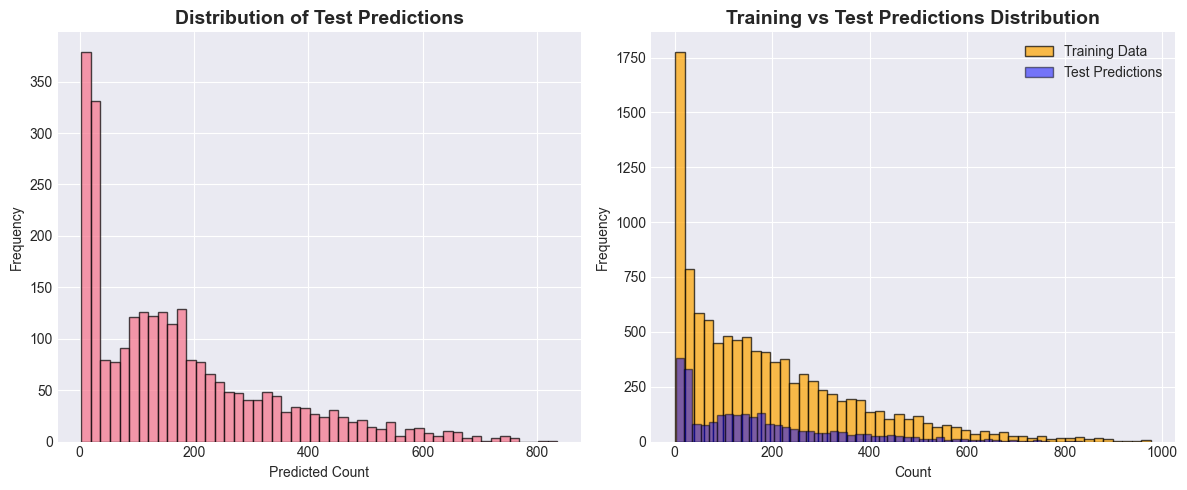

In [131]:
# Visualize test predictions distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Count')
plt.ylabel('Frequency')
plt.title('Distribution of Test Predictions', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
plt.hist(y.values, bins=50, edgecolor='black', alpha=0.7, color='orange', label='Training Data')
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.5, color='blue', label='Test Predictions')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Training vs Test Predictions Distribution', fontsize=14, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

In [132]:
print("="*80)
print("BIKE SHARING DEMAND PREDICTION - SUMMARY")
print("="*80)
print(f"\n1. Dataset:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Features engineered: {X.shape[1]}")

print(f"\n2. Best Model: {best_model_name}")
print(f"   - Validation RMSLE: {results[best_model_idx]['val_rmsle']:.4f} (Primary Metric)")
print(f"   - Validation RMSE: {results[best_model_idx]['val_rmse']:.2f}")
print(f"   - Validation R²: {results[best_model_idx]['val_r2']:.4f}")
print(f"   - Validation MAE: {results[best_model_idx]['val_mae']:.2f}")

print(f"\n3. Key Insights:")
print(f"   - Hour of day is the most important feature")
print(f"   - Temperature and 'feels like' temperature strongly correlate with demand")
print(f"   - Clear differences between working days and weekends")
print(f"   - Peak demand during rush hours (7-9 AM and 5-7 PM) on working days")

print(f"\n4. Model Performance Comparison (RMSLE):")
for i, result in enumerate(results):
    print(f"   {result['model_name']:25} - Val RMSLE: {result['val_rmsle']:.4f}, Val R²: {result['val_r2']:.4f}")

print(f"\n5. Output:")
print(f"   - Submission file created: submission.csv")
print(f"   - Predictions generated for {len(test_predictions)} test samples")

print(f"\n6. Evaluation Metric:")
print(f"   - RMSLE (Root Mean Squared Logarithmic Error) used as per assignment requirements")
print(f"   - RMSLE = sqrt(mean((log(pred+1) - log(actual+1))^2))")

print("\n" + "="*80)
print("Analysis complete! Ready for submission.")
print("="*80)

BIKE SHARING DEMAND PREDICTION - SUMMARY

1. Dataset:
   - Training samples: 10450
   - Test samples: 2613
   - Features engineered: 30

2. Best Model: Linear Regression (Log Transform)
   - Validation RMSLE: 0.7733 (Primary Metric)
   - Validation RMSE: 134.89
   - Validation R²: 0.4863
   - Validation MAE: 86.11

3. Key Insights:
   - Hour of day is the most important feature
   - Temperature and 'feels like' temperature strongly correlate with demand
   - Clear differences between working days and weekends
   - Peak demand during rush hours (7-9 AM and 5-7 PM) on working days

4. Model Performance Comparison (RMSLE):
   Linear Regression (Log Transform) - Val RMSLE: 0.7733, Val R²: 0.4863
   Ridge Regression (Log Transform) - Val RMSLE: 0.7733, Val R²: 0.4862
   Lasso Regression (Log Transform) - Val RMSLE: 0.7737, Val R²: 0.4879

5. Output:
   - Submission file created: submission.csv
   - Predictions generated for 2613 test samples

6. Evaluation Metric:
   - RMSLE (Root Mean Squa